### Diii.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.392e+05                  │              Nfcn = 653              │
│ EDM = 1.67e-07 (Goal: 0.0002)    │           time = 30.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬────────

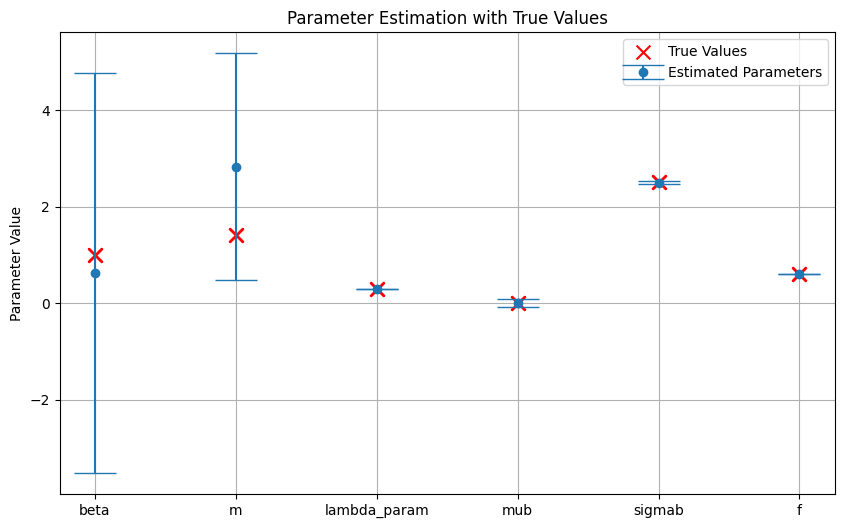

In [ ]:
#'''
!pip install iminuit
!pip install --upgrade iminuit
import numpy as np
from scipy.stats import crystalball, uniform, norm, expon
from iminuit import Minuit, cost
import matplotlib.pyplot as plt


# Signal and Background Definitions
class g_s:
    def __init__(self, beta, m, x_min=0, x_max=5):
        self.beta = beta
        self.m = m
        self.x_min = x_min
        self.x_max = x_max

    def pdf(self, x):
        norm_factor = crystalball.cdf(self.x_max, beta=self.beta, m=self.m) - \
                      crystalball.cdf(self.x_min, beta=self.beta, m=self.m)
        return crystalball.pdf(x, beta=self.beta, m=self.m) / norm_factor


class h_s:
    def __init__(self, lambda_param, y_min=0, y_max=10):
        self.lambda_param = lambda_param
        self.y_min = y_min
        self.y_max = y_max

    def pdf(self, y):
        norm_factor = expon.cdf(self.y_max, scale=1 / self.lambda_param) - \
                      expon.cdf(self.y_min, scale=1 / self.lambda_param)
        return expon.pdf(y, scale=1 / self.lambda_param) / norm_factor


class g_b:
    def __init__(self, x_min=0, x_max=5):
        self.x_min = x_min
        self.x_max = x_max

    def pdf(self, x):
        norm_factor = uniform.cdf(self.x_max, loc=self.x_min, scale=self.x_max - self.x_min) - \
                      uniform.cdf(self.x_min, loc=self.x_min, scale=self.x_max - self.x_min)
        return uniform.pdf(x, loc=self.x_min, scale=self.x_max - self.x_min) / norm_factor


class h_b:
    def __init__(self, mub, sigmab, y_min=0, y_max=10):
        self.mub = mub
        self.sigmab = sigmab
        self.y_min = y_min
        self.y_max = y_max

    def pdf(self, y):
        norm_factor = norm.cdf(self.y_max, loc=self.mub, scale=self.sigmab) - \
                      norm.cdf(self.y_min, loc=self.mub, scale=self.sigmab)
        return norm.pdf(y, loc=self.mub, scale=self.sigmab) / norm_factor



# Combined Function
def overall_function(x, y, beta, m, lambda_param, mub, sigmab, f):
    gs = g_s(beta, m)
    hs = h_s(lambda_param)
    gb = g_b()
    hb = h_b(mub, sigmab)

    signal = gs.pdf(x) * hs.pdf(y)
    background = gb.pdf(x) * hb.pdf(y)

    return f * signal + (1 - f) * background


# Generate Sample Data
def generate_samples(num_samples, beta, m, lambda_param, mub, sigmab, f):
    x_min, x_max = 0, 5
    y_min, y_max = 0, 10

    np.random.seed(42)
    accepted_X, accepted_Y = [], []
    z_max = 0.17  # Adjust based on pre-computed max value of overall_function

    while len(accepted_X) < num_samples:
        X = np.random.uniform(x_min, x_max, size=num_samples)
        Y = np.random.uniform(y_min, y_max, size=num_samples)
        Z = np.random.uniform(0, z_max, size=num_samples)
        f_values = overall_function(X, Y, beta, m, lambda_param, mub, sigmab, f)

        mask = Z < f_values
        accepted_X.extend(X[mask])
        accepted_Y.extend(Y[mask])

    return np.array(accepted_X[:num_samples]), np.array(accepted_Y[:num_samples])


# Define tdensity
def tdensity(x, y, beta, m, lambda_param, mub, sigmab, f):
    """
    Compute the overall probability density function for given data (x, y)
    and model parameters.
    """
    pdf = overall_function(x, y, beta, m, lambda_param, mub, sigmab, f)
    return pdf


# Initial Parameters
initial_params = {
    "beta": 1.0,
    "m": 1.4,
    "lambda_param": 0.3,
    "mub": 0.0,
    "sigmab": 2.5,
    "f": 0.6,
}

# Generate data
num_samples = 100000
x_data, y_data = generate_samples(num_samples, **initial_params)

# Define the cost function
nll_cost = cost.UnbinnedNLL(
    (x_data, y_data),
    lambda data, beta, m, lambda_param, mub, sigmab, f: tdensity(
        data[0], data[1], beta, m, lambda_param, mub, sigmab, f
    )
)

# Initialize Minuit
mm = Minuit(
    nll_cost,
    beta=1.0,
    m=1.4,
    lambda_param=0.3,
    mub=0.0,
    sigmab=2.5,
    f=0.6
)

# Set parameter limits
mm.limits["beta"] = (0.1, 5.0)
mm.limits["m"] = (0.1, 3.0)
mm.limits["lambda_param"] = (0.1, 5.0)
mm.limits["mub"] = (-5.0, 5.0)
mm.limits["sigmab"] = (0.1, 5.0)
mm.limits["f"] = (0.01, 0.99)

# Perform optimization
mm.migrad()  # Fit the parameters
print(mm.fmin)
mm.hesse() # Estimate error range


# Results
print(mm.params)
print(f"Estimated Parameters: {mm.values}")
print(f"Parameter Uncertainties: {mm.errors}")

# '''

plt.figure(figsize=(10, 6))

true_values = [1.0, 1.4, 0.3, 0.0, 2.5, 0.6] # for parameters in each of corresponding positions
plt.errorbar(
    x=["beta", "m", "lambda_param", "mub", "sigmab", "f"],
    y=list(mm.values),  # Estimated values
    yerr=list(mm.errors),  # Uncertainties
    fmt="o",
    label="Estimated Parameters",
    capsize=15
)

# Add true values as horizontal lines
for i, true_val in enumerate(true_values):
    plt.scatter(
        x=["beta", "m", "lambda_param", "mub", "sigmab", "f"],
        y=true_values,
        color="r",
        marker="x",
        s=100,
        label="True Values" if i == 0 else None
    )

plt.xticks(ticks=range(len(true_values)), labels=["beta", "m", "lambda_param", "mub", "sigmab", "f"])
plt.ylabel("Parameter Value")
plt.title("Parameter Estimation with True Values")
plt.legend()
plt.grid(True)
plt.show()


## E.

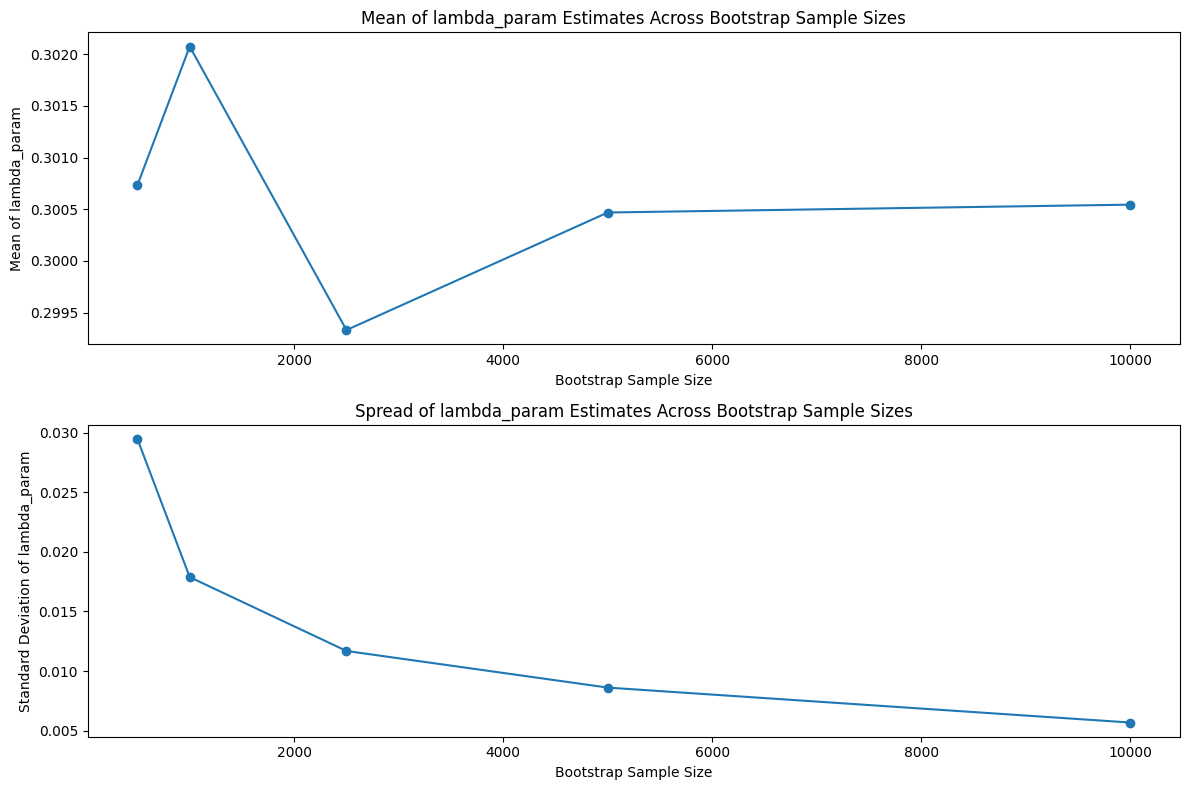

In [ ]:
# '''
!pip install iminuit
!pip install --upgrade iminuit
import numpy as np
from iminuit import Minuit
import matplotlib.pyplot as plt


# Bootstrap Data Generation
def generate_bootstrap_data(x_data, y_data, lambda_param, size):
    """Generate bootstrap samples from the fitted model."""
    sampled_indices = np.random.choice(len(x_data), size, replace=True)
    x_bootstrap = x_data[sampled_indices]
    y_bootstrap = y_data[sampled_indices]
    return x_bootstrap, y_bootstrap


# Re-Estimate lambda_param Using Minuit
def reestimate_lambda_param(x_bootstrap, y_bootstrap, beta, m, f, initial_lambda, bounds):
    """
    Re-estimate lambda_param for bootstrap samples using Minuit.
    """
    def nll(lambda_param):
        """Negative log-likelihood function."""
        # Use the fixed parameters and current lambda_param to compute the model
        model = overall_function(x_bootstrap, y_bootstrap, beta, m, lambda_param, mub=0.0, sigmab=2.5, f=f)
        return -np.sum(np.log(model + 1e-10))  # Avoid log(0)

    # Minuit setup
    minuit = Minuit(nll, lambda_param=initial_lambda)
    minuit.limits["lambda_param"] = bounds
    minuit.errordef = Minuit.LIKELIHOOD

    # Optimize
    minuit.migrad()
    if minuit.valid:
        return minuit.values["lambda_param"]
    else:
        return None


# Perform Parametric Bootstrapping
bootstrap_sizes = [500, 1000, 2500, 5000, 10000]
bootstrap_results = {size: [] for size in bootstrap_sizes}

# Parameters for the model
beta = 1.0
m = 1.4
lambda_param = 0.3
f = 0.6

# Perform bootstrapping
for size in bootstrap_sizes:
    for _ in range(250):  # Perform 250 bootstrap iterations
        # Generate bootstrap data
        x_bootstrap, y_bootstrap = generate_bootstrap_data(x_data, y_data, lambda_param, size)

        # Re-estimate lambda_param
        lambda_estimate = reestimate_lambda_param(
            x_bootstrap, y_bootstrap,
            beta=beta,
            m=m,
            f=f,
            initial_lambda=lambda_param,
            bounds=(0.1, 5.0)
        )

        if lambda_estimate is not None:
            bootstrap_results[size].append(lambda_estimate)

# Analyze Results
mean_estimates = {size: np.mean(bootstrap_results[size]) for size in bootstrap_sizes}
std_estimates = {size: np.std(bootstrap_results[size]) for size in bootstrap_sizes}
#'''

# Plot Results
plt.figure(figsize=(12, 8))

# Mean estimates
plt.subplot(2, 1, 1)
plt.plot(bootstrap_sizes, [mean_estimates[size] for size in bootstrap_sizes], marker="o")
plt.xlabel("Bootstrap Sample Size")
plt.ylabel("Mean of lambda_param")
plt.title("Mean of lambda_param Estimates Across Bootstrap Sample Sizes")

# Standard deviation of estimates
plt.subplot(2, 1, 2)
plt.plot(bootstrap_sizes, [std_estimates[size] for size in bootstrap_sizes], marker="o")
plt.xlabel("Bootstrap Sample Size")
plt.ylabel("Standard Deviation of lambda_param")
plt.title("Spread of lambda_param Estimates Across Bootstrap Sample Sizes")

plt.tight_layout()
plt.show()

F

    PDF normalisations:
	 0 11.229968378971932
	 1 0.9999999999999882


/usr/local/lib/python3.10/dist-packages/sweights/sweight.py:373: RuntimeWarning: invalid value encountered in scalar divide
  return sum(
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = q

    Integral of w*pdf matrix (should be close to the
                identity):
	[[nan nan]
	 [nan nan]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |   277.8097 |   277.8097 |    -0.00% |
	  1        |   222.1903 |   222.1903 |     0.00% |


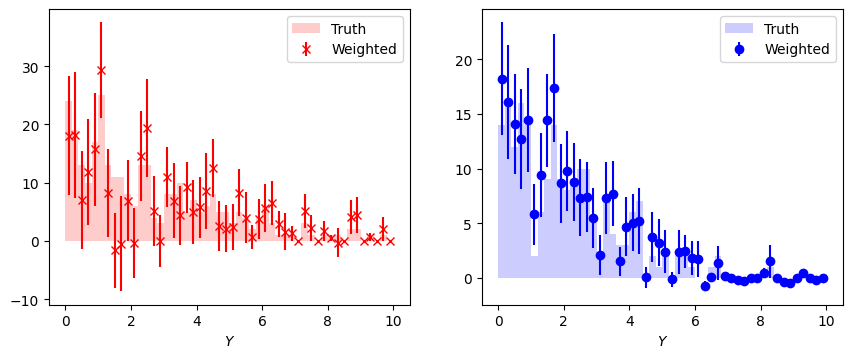

    PDF normalisations:
	 0 11.400252873257488
	 1 0.9999999999999882
    Integral of w*pdf matrix (should be close to the
                identity):
	[[nan nan]
	 [nan nan]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |   616.1409 |   616.1409 |     0.00% |
	  1        |   383.8591 |   383.8591 |    -0.00% |


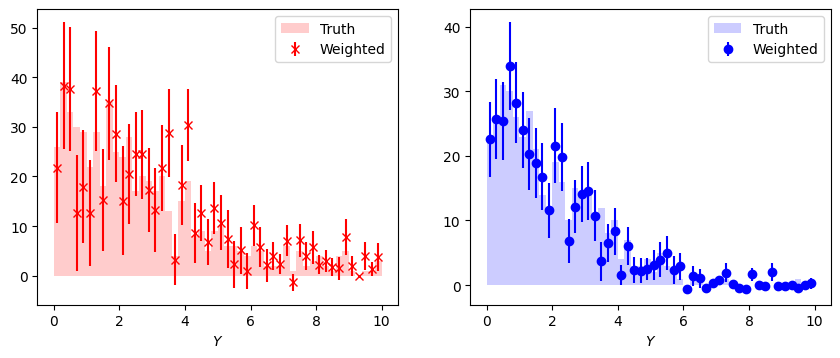

    PDF normalisations:
	 0 11.201385512369677
	 1 0.9999999999999882
    Integral of w*pdf matrix (should be close to the
                identity):
	[[nan nan]
	 [nan nan]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  1492.3016 |  1492.3016 |    -0.00% |
	  1        |  1007.6984 |  1007.6984 |     0.00% |


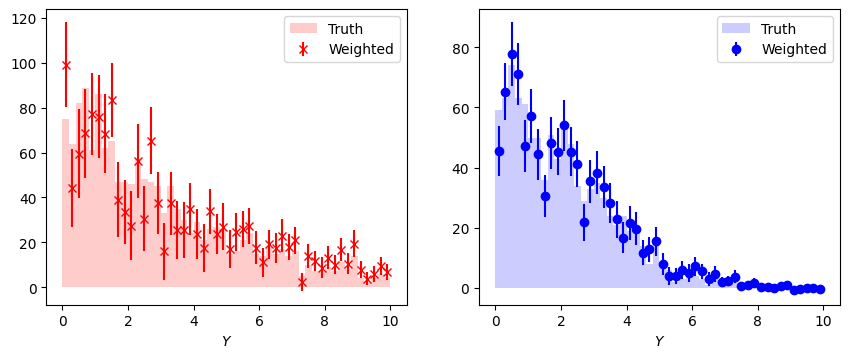

    PDF normalisations:
	 0 5.164618026551685
	 1 0.9999999999999882
    Integral of w*pdf matrix (should be close to the
                identity):
	[[nan nan]
	 [nan nan]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  3031.8750 |  3031.8750 |    -0.00% |
	  1        |  1968.1250 |  1968.1250 |     0.00% |


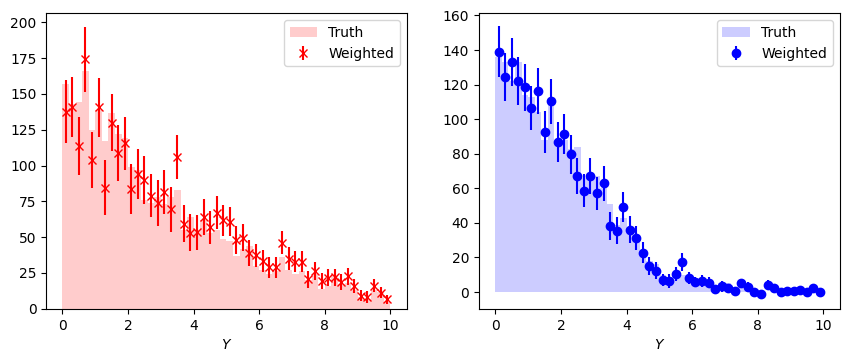

    PDF normalisations:
	 0 11.400661081450314
	 1 0.9999999999999882
    Integral of w*pdf matrix (should be close to the
                identity):
	[[nan nan]
	 [nan nan]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  6071.9006 |  6071.9006 |     0.00% |
	  1        |  3928.0994 |  3928.0994 |     0.00% |


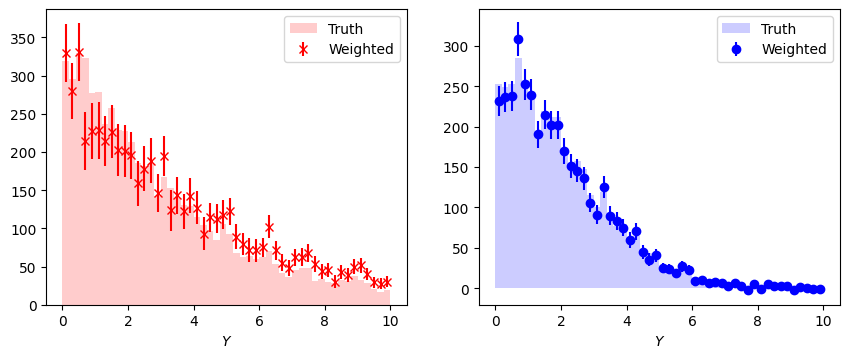

<ipython-input-47-3744a539e6e3>:114: RuntimeWarning: invalid value encountered in log
  nll -= np.log(total_pdf + 1e-10)  # Avoid log(0)


Sample Size: 500, Estimated lambda_param: 0.3000, Error: 0.0000
Sample Size: 1000, Estimated lambda_param: 0.3000, Error: 0.0000
Sample Size: 2500, Estimated lambda_param: 0.3000, Error: 0.0000
Sample Size: 5000, Estimated lambda_param: 0.3000, Error: 0.0000
Sample Size: 10000, Estimated lambda_param: 0.4527, Error: 0.1061


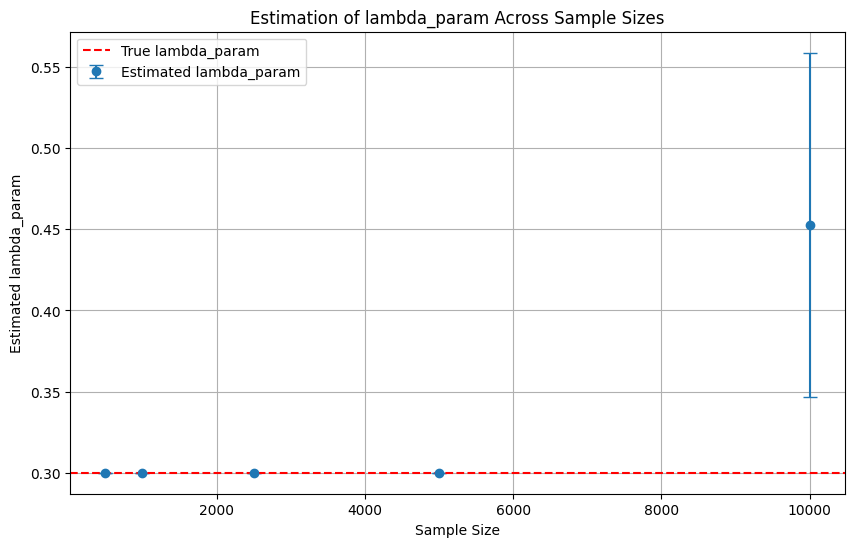

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sweights import SWeight
from scipy.stats import expon
from iminuit import Minuit

# Signal and Background PDFs
def signal_pdf(x, beta, m, x_min=0, x_max=5):
    gs = g_s(beta, m)
    norm_factor = crystalball.cdf(x_max, beta=beta, m=m) - crystalball.cdf(x_min, beta=beta, m=m)
    return gs.pdf(x) / norm_factor

def background_pdf(x, x_min=0, x_max=5):
    gb = g_b()
    norm_factor = uniform.cdf(x_max, loc=x_min, scale=x_max - x_min) - uniform.cdf(x_min, loc=x_min, scale=x_max - x_min)
    return gb.pdf(x) / norm_factor

def overall_function_x(x, beta, m, f):
    signal = g_s(beta, m).pdf(x)
    background = g_b().pdf(x)
    return f * signal + (1 - f) * background

def xdensity(x, beta, m, f):
    """
    Compute the overall probability density function for given data (x)
    and model parameters.
    """
    pdf = overall_function_x(x, beta, m, f)
    return pdf

def perform_sweights(sample_size, beta, m, f, lambda_param, mub, sigmab):
    x_data_s, y_data_s = generate_samples(int(sample_size*f), beta, m, lambda_param, mub, sigmab, 1.)
    x_data_b, y_data_b = generate_samples(sample_size-int(sample_size*f), beta, m, lambda_param, mub, sigmab, 0.)

    # Yields (true values for signal and background)
    x_data = np.concatenate((x_data_s, x_data_b), axis=0)
    y_data = np.concatenate((y_data_s, y_data_b), axis=0)

    # Estimate beta and m from x_data.
    nll_cost = cost.UnbinnedNLL(
        x_data,
        lambda data, beta, m, f: xdensity(
            data, beta, m, f
        )
    )

    # Initialize Minuit
    mm = Minuit(
        nll_cost,
        beta=1.0,
        m=1.4,
        f=0.6
    )

    # Set parameter limits
    mm.limits["beta"] = (0.1, 5.0)
    mm.limits["m"] = (0.1, 3.0)
    mm.limits["f"] = (0.01, 0.99)

    # Perform optimization
    mm.migrad()  # Fit the parameters

    beta, m, f = mm.values
    sy = f * sample_size
    by = (1 - f) * sample_size

    # Signal and background PDFs for x
    sf = lambda x: signal_pdf(x, beta, m)
    bf = lambda x: background_pdf(x)

    # Apply sweights
    sweighter = SWeight(x_data, pdfs=[sf, bf], yields=[sy, by])

    # Signal and background weights
    signal_weights = sweighter.get_weight(0, x_data)
    background_weights = sweighter.get_weight(1, x_data)
    yrange=(0,10)
    ysw, ye = np.histogram( y_data, bins=50, range=yrange, weights=signal_weights )
    ybw, ye = np.histogram( y_data, bins=50, range=yrange, weights=background_weights )

    ysw2, ye = np.histogram( y_data, bins=50, range=yrange, weights=signal_weights**2 )
    ybw2, ye = np.histogram( y_data, bins=50, range=yrange, weights=background_weights**2 )

    cy = 0.5*(ye[1:]+ye[:-1])

    fig, ax = plt.subplots(1, 2, figsize=(0.8*12.8, 0.8*4.8))

    ax[0].errorbar( cy, ysw, ysw2**0.5, fmt='rx', label='Weighted' )
    ax[0].hist( y_data_s, bins=50, range=yrange, fc='r', alpha=0.2, label='Truth' )
    ax[0].legend()
    ax[1].errorbar( cy, ybw, ybw2**0.5, fmt='bo', label='Weighted' )
    ax[1].hist( y_data_b, bins=50, range=yrange, fc='b', alpha=0.2, label='Truth' )
    ax[1].legend()

    ax[0].set_xlabel('$Y$')
    ax[1].set_xlabel('$Y$')
    plt.show()
    plt.savefig(f"histo{sample_size}.png")
    plt.close()

    # Return relevant data for lambda_param fitting
    return y_data, ysw, ybw

# Negative Log-Likelihood for lambda_param
def nll_lambda_param(lambda_param, y_vals, signal_proj, background_proj):
    """
    Negative log-likelihood for lambda_param estimation using weighted y_vals.
    Loops over each value in y_vals.
    """
    nll = 0.0
    for y, s_proj, b_proj in zip(y_vals, signal_proj, background_proj):
        signal_pdf_y = expon.pdf(y, scale=1 / lambda_param)
        total_pdf = signal_pdf_y * s_proj + b_proj
        nll -= np.log(total_pdf + 1e-10)  # Avoid log(0)
    return nll

# Function to estimate lambda_param for each sample size
def estimate_lambda_param(results, initial_guess=0.3, bounds=(0.1, 5.0)):
    estimates = {}
    for sample_size, (y_vals, signal_proj, background_proj) in results.items():
        # Define the Minuit optimization
        minuit = Minuit(
            lambda lambda_param: nll_lambda_param(lambda_param, y_vals, signal_proj, background_proj),
            lambda_param=initial_guess,
        )
        minuit.limits["lambda_param"] = bounds
        minuit.errordef = Minuit.LIKELIHOOD

        # Perform the optimization
        minuit.migrad()
        estimates[sample_size] = {
            "lambda_param": minuit.values["lambda_param"],
            "error": minuit.errors["lambda_param"]
        }

    return estimates

# Perform analysis for different sample sizes
sample_sizes = [500, 1000, 2500, 5000, 10000]
results = {}

for sample_size in sample_sizes:
    y_vals, signal_proj, background_proj = perform_sweights(
        sample_size, beta=1.0, m=1.4, f=0.6, lambda_param=0.3, mub=0.0, sigmab=2.5
    )
    results[sample_size] = (y_vals, signal_proj, background_proj)

# Perform estimation for each sample size
lambda_estimates = estimate_lambda_param(results)

# Display results
for size, estimate in lambda_estimates.items():
    print(f"Sample Size: {size}, Estimated lambda_param: {estimate['lambda_param']:.4f}, Error: {estimate['error']:.4f}")

# Plot results
sample_sizes = list(lambda_estimates.keys())
lambda_values = [lambda_estimates[size]["lambda_param"] for size in sample_sizes]
lambda_errors = [lambda_estimates[size]["error"] for size in sample_sizes]

plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, lambda_values, yerr=lambda_errors, fmt="o", capsize=5, label="Estimated lambda_param")
plt.axhline(0.3, color="r", linestyle="--", label="True lambda_param")
plt.xlabel("Sample Size")
plt.ylabel("Estimated lambda_param")
plt.title("Estimation of lambda_param Across Sample Sizes")
plt.legend()
plt.grid(True)
plt.show()
